# Usage example of the GOMEZ (Iterative IDW) algorithm
The GOMEZ algorithm will generate a rain map from microwave links' average rain rate.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mlcolors
import matplotlib.image as mpimg
from mpl_toolkits.basemap import Basemap
from iterative_IDW import IdwIterative, create_virtual_gauges, calc_atten_from_rain
from pyproj import Proj, transform

## Define functions for free path loss (optional)

In [2]:
def path_loss_atten(length, freq, gain = 0):
    ''' calculate the attenuation of a link due to path loss
    see en.wikipedia.org/wiki/Free-space_path_loss for details '''    
    # convert=length*freq*(10**12) #conversion units - GHz*km to Hz*m
    # length in KM, freq in GHz, gain in dB
    path_loss = 20*np.log10(length*freq) + 92.45 + gain
    return path_loss

def remove_free_path_loss(df):
    ''' remove free path loss attenuation from df['A'] '''
    df['A'] =  df.apply(lambda cml: cml['A'] - path_loss_atten(cml['L'], cml['F']), axis=1)
    
    # set negative attenuations to 0
    df['A'] = df['A'].apply(lambda a: max(0.0,a))
    
    return df

## Define function for conversion of latitude/longitude to UTM

In [3]:
def lat_lon_to_UTM(df, p_LL, p_UTM):
    ''' convert latitude/longitude to UTM (easting/northing in units of meter) '''
    df['xa'], df['ya'] = transform(p1=p_LL, # lat/lon
                                   p2=p_UTM, # utm in meters
                                   x=df['xa'].values, y=df['ya'].values)
    df['xb'], df['yb'] = transform(p1=p_LL, # lat/lon
                                   p2=p_UTM, # utm in meters
                                   x=df['xb'].values, y=df['yb'].values)
    return df

## Load link data (metadata and rawdata)
Load a CSV file with the following data (mandatory data):
<table align='left'>
<tr><td bgcolor='#DDDDDD'>Column name:</td><td bgcolor='#DDDDDD'>Description:</td></tr>
<tr><td>xa</td><td>longitude of site A of the link</td></tr>
<tr><td>ya</td><td>latitude of site A of the link</td></tr>
<tr><td>xb</td><td>longitude of site B of the link</td></tr>
<tr><td>yb</td><td>latitude of site B of the link</td></tr>
<tr><td>Length</td><td>length of the link in kilometers</td></tr>
<tr><td>ITU_a1</td><td>ITU power law parameter a of the link</td></tr>
<tr><td>ITU_b1</td><td>ITU power law parameter a of the link</td></tr>
<tr><td>A_1</td><td>attenuation of the link in dB (may include free path loss)</td></tr>
<tr><td>Rain1</td><td>average rain along the link in mm/hr</td></tr>
<tr><td>Freq_1</td><td>the transmission frequency of the link in GHz</td></tr>
<tr><td colspan=2><b>Note:</b> columns ending with "1" indicate data for channel 1 of the link.<br>
Data for channel 2 should have the following column names: <i>ITU_a2, ITU_b2, A_2, Rain2, Freq_2</i></td></tr>
</table>

In [4]:
df = pd.read_csv('data/rain_simulation.csv', index_col=None)
df.head()

,SP,Link_num,Length,Freq_1,Polar_1,ITU_a1,ITU_b1,Freq_2,Polar_2,ITU_a2,ITU_b2,xa,ya,xb,yb,Rain1,Rain2,A_1,A_2
0,-,0,9.990667,20.0,V,0.0691,1.065,21.0,V,0.077186,1.056791,34.000000,31.0,34.009944,31.0895,9.896294,9.888328,7.93751,8.713724
1,-,1,9.990667,20.0,V,0.0691,1.065,21.0,V,0.077186,1.056791,34.019889,31.0,34.029833,31.0895,16.183524,16.176972,13.33751,14.713724
2,-,2,9.990667,20.0,V,0.0691,1.065,21.0,V,0.077186,1.056791,34.039778,31.0,34.049722,31.0895,19.090166,19.085060,16.03751,17.413724
3,-,3,9.990667,20.0,V,0.0691,1.065,21.0,V,0.077186,1.056791,34.059667,31.0,34.069611,31.0895,16.262688,16.255989,13.33751,14.713724
4,-,4,9.990667,20.0,V,0.0691,1.065,21.0,V,0.077186,1.056791,34.079556,31.0,34.089500,31.0895,9.992749,9.984573,7.93751,8.713724


## Data pre-processing
perform the following pre-processing steps:
<ul>
<li>Rename columns to names required by the algorithm</li>
<li>Find min/max latitude and longitude for the rain map grid</li>
<li>Convert link coordinates from latitude/longitude to UTM</li>
<li>Divide each link to virtual rain gauges</li>
</ul>

In [5]:
# for coordinate conversion from Longitude/Latitude to UTM (and vice versa)
p_LL = Proj(init='epsg:4326')
utm_epsg = '3395' # can also use epsg '3857'
p_UTM = Proj(init='epsg:'+utm_epsg)

# rename columns for the IterativeIdw algorithm (using only channel 1 of each cml)
col_names = {'Length':'L', 'A_1':'A',
             'ITU_a1':'a', 'ITU_b1':'b',
             'Freq_1':'F', 'Rain1':'R'}
df = df.rename(columns = col_names)

# take only relevant columns for the algoritm
df = df[['xa','ya','xb','yb','L','a','b','F','R']]

# optional: remove free path loss from df['A']
#df = remove_free_path_loss(df)

# find min/max latitude and longitude (for rain map grid)
xs = np.concatenate((df['xa'].values, df['xb'].values))
ys = np.concatenate((df['ya'].values, df['yb'].values))
min_lon, max_lon = xs.min(), xs.max()
min_lat, max_lat = ys.min(), ys.max()

# convert df[['xa','ya','xb','yb']] to UTM (in meters)
df = lat_lon_to_UTM(df, p_LL, p_UTM)

# compute links rain induced attenuation in df['A'] using df[['R','L','a','b']]
df = calc_atten_from_rain(df)

# create virtual gauges in df[['x','y','z']] using df[['xa','ya','xb','yb']]
number_of_virtual_gauges = 3 # the number of virtual gauges along each cml
df = create_virtual_gauges(df, num_gauges=number_of_virtual_gauges)

# can also define distance between to virtual gauges (each link's length will determine the number of virtual gauges)
# df = create_virtual_gauges(df, gauge_length = 2.0)

df[['x','y','z']].head()

,x,y,z
0,"(3785139.4397488562, 3785416.1925264113, 37856...","(3613638.061007402, 3616530.9366838178, 361942...","(9.896293711233275, 9.896293711233275, 9.89629..."
1,"(3787353.461969294, 3787630.2147468487, 378790...","(3613638.061007402, 3616530.9366838178, 361942...","(16.18352352542024, 16.18352352542024, 16.1835..."
2,"(3789567.484189733, 3789844.236967288, 3790120...","(3613638.061007402, 3616530.9366838178, 361942...","(19.090166096680587, 19.090166096680587, 19.09..."
3,"(3791781.5064101713, 3792058.2591877263, 37923...","(3613638.061007402, 3616530.9366838178, 361942...","(16.262687821016915, 16.262687821016915, 16.26..."
4,"(3793995.52863061, 3794272.2814081647, 3794549...","(3613638.061007402, 3616530.9366838178, 361942...","(9.99274877550564, 9.99274877550564, 9.9927487..."


## Load (or create) a 2D grid for the rain map
Load a grid from a file (e.g: CSV file) or create a grid with custom x/y range and resolution using the <b>create_grid</b> function.<br>
<font color="red">This algorithm will use the cmls to estimate the rain rate at each point of this grid.</font>

In [6]:
def create_grid(x_min, x_max, y_min, y_max, res_x, res_y):
    # create the grid for the rain
    px = int(np.rint((x_max - x_min) / res_x)) # number of grid x values
    py = int(np.rint((y_max - y_min) / res_y)) # number of grid y values

    xi = np.linspace(x_min, x_max, px)
    yi = np.linspace(y_min, y_max, py)

    xgrid, ygrid = np.meshgrid(xi, yi)
    return xgrid, ygrid

## How to use the create_grid function:
<b>#get min/max lon and lat values (for grid of (x,y) points)</b>
<br>
xs = np.concatenate((df['xa'].values, df['xb'].values))<br>
ys = np.concatenate((df['ya'].values, df['yb'].values))<br>
x_min, x_max = xs.min(), xs.max()<br>
y_min, y_max = ys.min(), ys.max()<br>

<b>#choose the resolution of the grid (in meters)</b>
<br>
res_x, res_y = 100, 100<br>
xgrid, ygrid = create_grid(x_min, x_max, y_min, y_max, res_x, res_y)<br><br>
<font color="red">Instead of using the create_grid function, we will use the grid of the ground truth rain map.</font>

In [7]:
# load grid from rain ground truth map
xgrid = pd.read_csv("data/rain_simulation_X.csv", header=None, index_col=None).values
ygrid = pd.read_csv("data/rain_simulation_Y.csv", header=None, index_col=None).values

res_x = abs(xgrid[0,0] - xgrid[0,1])
res_y = abs(xgrid[0,0] - xgrid[0,1])
print("Shape of xgrid:{}, min x: {}, max x: {}, resolution: {}".format(xgrid.shape, xgrid.min(), xgrid.max(), res_x))
print("Shape of ygrid:{}, min y: {}, max y: {}, resolution: {}".format(ygrid.shape, ygrid.min(), ygrid.max(), res_y))

Shape of xgrid:(151L, 130L), min x: 3783370.0, max x: 3796270.0, resolution: 100.0
Shape of ygrid:(151L, 130L), min y: 3609020.0, max y: 3624020.0, resolution: 100.0


## Set up the algorithm parameters
The GOMEZ (iterative IDW) algorithm requires the following parameters:
<ul>
<li><b>ROI</b> - Radius of influence in meters, determines the radius for which.<br>
Set ROI to 0 to use automatic estimation of the ROI.</li>
<li><b>max_iterations</b> - max number of iterations the algorithm will perform.<br></li>
<li><b>tolerance</b> - a stop condition for the algorithm (norm of change between iterations, in mm/hr).<br>
Set tolerance to 0 to allow the algorithm to perform maximum number of iterations.</li>
<li><b>quantization</b> - dB quantization of the attenuation measurements.</li>
</ul>

## How to run the algorithm
Create a variable with an instance of the IdwItertive class with the desired parameters (ROI, max_iterations, etc.):<br>
Call the variable (as if calling a function) and provide the following arguments:
<ul>
<li><b>df</b> - a pandas dataframe with all the cml data (as we have loaded in the beginning of the notebook).</li>
<li><b>xgrid, ygrid</b> - the algorithm will estimate the rate rate at each (x, y) point in xgrid, ygrid.</li>
<li><b>quantization</b> - see quantization in "Set up algorithm parameters".</li>
</ul>

<b>Example:</b>
<code><i>
cml_interp = IdwIterative(ROI=1000, max_iterations=5, tolerance=0.1)
cml_interp(df, xgrid, ygrid, quantization)
</i></code>

## Run the algorithm

In [8]:
# set up parameters
ROI = 0
tolerance = 0
quantization = 0.3
max_iters = [1, 5] # a list of # of iterations to test

# run the algorithm
zgrids = []
for max_iterations in max_iters:
    cml_interp = IdwIterative(ROI, max_iterations, tolerance) # initialization
    zgrids.append(cml_interp(df, xgrid, ygrid, quantization)) # perform the actual calculation

ROI = cml_interp.ROI # the ROI used by the algorithm (user defined or estimated)

Radius of influence: 10285.7798687
Running iteration 0
Processing finished.

Radius of influence: 10285.7798687
Running iteration 0
Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4
Processing finished.



## Draw the results

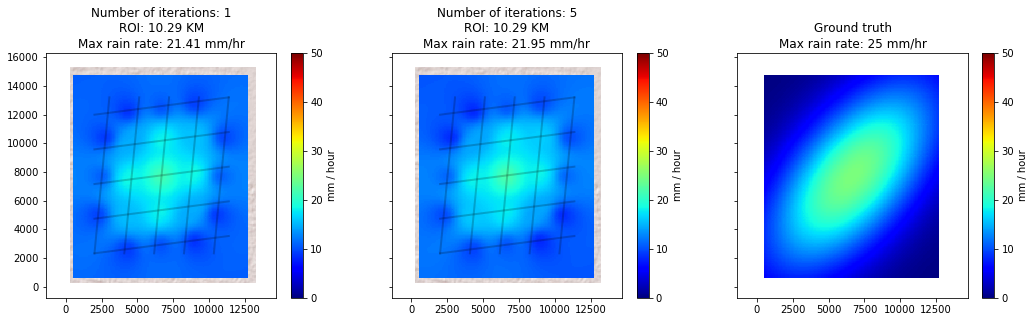

In [10]:
# normalize colormap
c_map = plt.cm.get_cmap('jet') # use 'jet' colormap
mi = min([Z.min() for Z in zgrids])
ma = max([Z.max() for Z in zgrids])
norm = mlcolors.Normalize(vmin=mi, vmax=ma)
levels = np.linspace(mi, ma, 100)

# set up matplotlib-basemap background map for all the rain maps
pct = 0.05 # increase limits of map by 5% for better visualization
dx = (xgrid.max() - xgrid.min()) * pct
dy = (ygrid.max() - ygrid.min()) * pct
 
# convert from UTM to longitude/latitude
min_lon, min_lat = transform(p1=p_UTM, p2=p_LL,
                             x=xgrid.min() - dx, y=ygrid.min() - dy)

max_lon, max_lat = transform(p1=p_UTM, p2=p_LL,
                             x=xgrid.max() + dx, y=ygrid.max() + dy)

# set up matplotlib figure figure (fig_map and ax_map are only used to create background map)
fig_map, ax_map = plt.subplots()

# EPSG:3395 refer to http://spatialreference.org/ref/epsg/wgs-84-world-mercator/
m = Basemap(projection='merc',
            llcrnrlat=min_lat,urcrnrlat=max_lat,
            llcrnrlon=min_lon,urcrnrlon=max_lon,
            lat_ts=20, resolution='c', epsg = utm_epsg)

m.arcgisimage(service='World_Shaded_Relief', xpixels=500, verbose=False)

plt.axis('off')
plt.savefig("bg_map.png", bbox_inches='tight', pad_inches=0) # save background map
plt.close(fig_map)

max_x, max_y = m(max_lon, max_lat)
min_x, min_y = m(min_lon, min_lat)

# load the background map (instead of creating the image for every subplot)
img = mpimg.imread("bg_map.png")

# draw the rain maps over time
fig_rows = 1
fig_cols = len(zgrids) + 1 # number of subplots to draw (+1 for ground truth)

# calculate figure size
fsize_x = fig_cols * int(abs(max_x - min_x)/1e3) * 0.45
fsize_y = fig_rows * int(abs(max_y - min_y)/1e3) * 0.3

# create figure with subplots
fig, ax = plt.subplots(fig_rows, fig_cols,
                       sharex=True, sharey=True,
                       figsize=(fsize_x, fsize_y))

# max rain value (for colorbar)  
max_R = 50

# convert cmls to map coordinates
xx, yy = transform(p1=p_UTM, p2=p_LL, x=df['xa'].values, y=df['ya'].values)
xx, yy = m(xx, yy)
cml_site_a = zip(xx.tolist(),yy.tolist())

xx, yy = transform(p1=p_UTM, p2=p_LL, x=df['xb'].values, y=df['yb'].values)
xx, yy = m(xx, yy)
cml_site_b = zip(xx.tolist(),yy.tolist())

# convert grid to map coordinates
X, Y = transform(p1=p_UTM, p2=p_LL, x=cml_interp.xgrid, y=cml_interp.ygrid) # convert from meters to lat/lon
X, Y = m(X, Y) # from lat/lon to basemap map coordinates
                 
# draw a the map+links+rain for each generated zgrids value
if type(ax) != np.ndarray:
    ax = np.array([ax])

for i, axi in enumerate(ax[:-1]):
    # background geographic map
    axi.imshow(img, extent=[min_x, max_x, min_y, max_y])
    
    # plot all cmls as lines
    for A, B in zip(cml_site_a, cml_site_b):
        axi.plot([A[0],B[0]], [A[1],B[1]], color='k', alpha=0.2, linewidth=2)
        
    Z = zgrids[i]        
    Z = np.ma.masked_where(np.isnan(Z), Z) # set the transparent values 
    pc = axi.pcolormesh(X - res_x/2.0, Y - res_y/2.0, Z,
                        cmap=c_map,
                        vmin=0, vmax=max_R) # levels = np.linspace(0,max_R,100)

    # optional: plot grid points (where the IDW has calculated the rain values)
    #axi.scatter(X[:-1,:-1], Y[:-1,:-1], color = 'k', s = 1)
    
    title = "Number of iterations: {}\nROI: {:.2f} KM\nMax rain rate: {:.2f} mm/hr".format(max_iters[i], ROI/1000.0, Z.max())
    axi.set_title(title)
    
    # create colorbar with mm/hour label
    fig.colorbar(pc, ax=axi, label='mm / hour')
    

# add ground truth rain map
ground_truth = pd.read_csv("data/rain_simulation_Z.csv", header=None, index_col=None).values
Z = np.ma.masked_where(np.isnan(ground_truth), ground_truth) # set the transparent values 
pc = ax[-1].pcolormesh(X - res_x/2.0, Y - res_y/2.0, Z, cmap = c_map, vmin = 0, vmax = max_R)
title = "Ground truth\nMax rain rate: {} mm/hr".format(25)
ax[-1].set_title(title)
fig.colorbar(pc, ax=ax[-1], label='mm / hour')

plt.show()

## Compare algorithm results to ground truth with MSE

In [11]:
def MSE(ground_truth, algorithm_result):
    return ((ground_truth - algorithm_result)**2.0).mean(axis=None)

for zgrid, max_iter in zip(zgrids, max_iters):
    print("After {} iteration(s) the MSE is {:.2f}".format(max_iter, MSE(ground_truth, zgrid)))

After 1 iteration(s) the MSE is 26.37
After 5 iteration(s) the MSE is 24.43
